In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.compat import v1 as tf1
from tensorflow.keras import layers as tfkl
import pandas as pd
import sklearn
import os

os.environ["CUDA_VISIBLE_DEVICES"]='1'

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn import metrics


from dctm import correlated_topic_model as ctmd
from dctm import dynamic_correlated_topic_model as dctm
from sklearn import metrics, preprocessing

from imp import reload

from dctm import correlated_topic_model as ctmd
from dctm import dynamic_correlated_topic_model as dctm

from dctm import datasets
import statsmodels.api as sm


/home/2064240P/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [6]:
data = pd.read_csv("malaria/pb10xIDC_counts.csv",header=0,index_col=0)

In [7]:
data

,AAACCTGAGCACCGTC,AAACCTGAGCGCTTAT,AAACGGGAGGGTCGAT,AAAGATGAGTCACGCC,AAAGCAAAGTTAAGTG,AAAGCAATCGTAGGAG,AAATGCCCATGGGACA,AACACGTGTAAACCTC,AACCATGTCTAGAGTC,AACCGCGAGATCCGAG,...,TGGCGCAGTCTAAACC,TGTATTCAGCGTGAAC,TGTCCCAAGAAGGACA,TGTCCCATCCGCAAGC,TGTTCCGGTAGTGAAT,TTATGCTCACTCGACG,TTCTCCTGTGTCCTCT,TTGACTTGTCTAAAGA,AGCTTGACAATAGAGT,CCGGGATCACGTTGGC
PBANKA_0000301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PBANKA_0000600,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PBANKA_0001001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PBANKA_0001101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PBANKA_0001201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PBANKA_MIT0270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PBANKA_MIT0280,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
PBANKA_MIT0310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PBANKA_MIT0350,5,2,5,2,2,2,1,0,0,0,...,1,1,0,1,0,0,0,0,0,0


In [8]:
metadata = pd.read_csv("malaria/pb10xIDC_pheno.csv",header=0,index_col=0)

In [9]:
metadata = metadata.sort_values(['clock_pseudotime'],ascending=True)

In [11]:
data = data.T

In [12]:
data.head()

,PBANKA_0000301,PBANKA_0000600,PBANKA_0001001,PBANKA_0001101,PBANKA_0001201,PBANKA_0006300,PBANKA_0007801,PBANKA_0008101,PBANKA_0100021,PBANKA_0100041,...,PBANKA_MIT0170,PBANKA_MIT0180,PBANKA_MIT0190,PBANKA_MIT0210,PBANKA_MIT0220,PBANKA_MIT0270,PBANKA_MIT0280,PBANKA_MIT0310,PBANKA_MIT0350,PBANKA_MIT0360
AAACCTGAGCACCGTC,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,5,1
AAACCTGAGCGCTTAT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,2,0
AAACGGGAGGGTCGAT,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,5,0
AAAGATGAGTCACGCC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
AAAGCAAAGTTAAGTG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,2,0


In [14]:
data.columns

Index(['PBANKA_0000301', 'PBANKA_0000600', 'PBANKA_0001001', 'PBANKA_0001101',
       'PBANKA_0001201', 'PBANKA_0006300', 'PBANKA_0007801', 'PBANKA_0008101',
       'PBANKA_0100021', 'PBANKA_0100041',
       ...
       'PBANKA_MIT0170', 'PBANKA_MIT0180', 'PBANKA_MIT0190', 'PBANKA_MIT0210',
       'PBANKA_MIT0220', 'PBANKA_MIT0270', 'PBANKA_MIT0280', 'PBANKA_MIT0310',
       'PBANKA_MIT0350', 'PBANKA_MIT0360'],
      dtype='object', length=4890)

In [18]:
vocabulary = np.array(data.columns)

In [19]:
metadata.head()

,nGene,nUMI,Prediction.Spearman.,r.Spearman.,Prediction.Pearsons.,r.Pearsons.,res.0.8,is_doublet,is_5k,total_features,...,pct_counts_top_100_features,pct_counts_top_200_features,pct_counts_top_500_features,is_cell_control,absclust,stage_pred,PC1,PC2,bulk,clock_pseudotime
TCAGGTATCAGCAACT,451,1346,22,0.326402,Pb_22hr.dat,0.367632,14,0,0,451,...,65.081724,81.277860,100.000000,False,5,5,2.504200,-6.275598,22,0.000000
ATCCACCCAATCCGAT,519,1436,22,0.319430,Pb_22hr.dat,0.349720,14,0,0,519,...,59.958217,75.557103,98.676880,False,5,5,2.476191,-6.467503,22,0.003817
CTACACCGTCGCGGTT,467,1182,24,0.276008,Pb_22hr.dat,0.279460,14,0,0,467,...,59.221658,76.818951,100.000000,False,5,5,2.455201,-6.411419,22,0.008311
CGAGAAGAGTCGATAA,524,1411,24,0.257207,Pb_22hr.dat,0.273096,18,0,0,524,...,61.233168,77.037562,98.299079,False,5,5,2.496019,-4.740262,22,0.019956
GTCTTCGAGATAGGAG,496,1338,24,0.295644,Pb_22hr.dat,0.348892,18,0,0,496,...,59.715994,76.382661,100.000000,False,5,5,2.340442,-6.322575,22,0.031456


In [20]:
timestamps = metadata['clock_pseudotime']

In [21]:
timestamps

TCAGGTATCAGCAACT    0.000000
ATCCACCCAATCCGAT    0.003817
CTACACCGTCGCGGTT    0.008311
CGAGAAGAGTCGATAA    0.019956
GTCTTCGAGATAGGAG    0.031456
                      ...   
GGCTGGTAGACTTTCG    6.243597
CTTAGGACACCACGTG    6.250587
GTAGGCCAGGGCTCTC    6.257192
ACGGGCTCATGCTAGT    6.260968
TTCTTAGCACAGGTTT    6.272143
Name: clock_pseudotime, Length: 4763, dtype: float64

In [22]:
data.shape

(4763, 4890)

In [23]:
scaler = sklearn.preprocessing.MinMaxScaler([-1, 1])
index_points = scaler.fit_transform(np.array(timestamps).reshape(-1,1))

In [24]:
X = np.expand_dims(data.values.astype(np.float64),-2)

In [25]:
np.random.seed(42)
(X_tr, X_ts, index_tr, index_ts, X_tr_sorted, X_ts_sorted,
 index_tr_sorted, index_ts_sorted
) = datasets.train_test_split(X, index_points)

In [26]:
batch_size = 20
n_train_samples = X_tr.shape[0]

dataset = tf.data.Dataset.zip(
    tuple(map(tf.data.Dataset.from_tensor_slices,
        (X_tr, index_tr))))
dataset = dataset.shuffle(n_train_samples, reshuffle_each_iteration=True)
data_tr = dataset.batch(batch_size)

In [27]:
X_tr.shape

(3572, 1, 4890)

In [29]:
inducing_index_points_beta = np.linspace(-1, 1, 6)[:, None]
inducing_index_points_mu = np.linspace(-1, 1, 6)[:, None]
inducing_index_points_ell = np.linspace(-1, 1, 6)[:, None]

dtype = np.float64
amplitude_beta = tfp.util.TransformedVariable(
    1., bijector=tfb.Softplus(), dtype=dtype, name='amplitude_beta')
length_scale_beta = tfp.util.TransformedVariable(
    7.5, bijector=tfb.Softplus(), dtype=dtype,
    name='length_scale_beta')
kernel_beta = tfk.MaternOneHalf(amplitude=amplitude_beta, length_scale=length_scale_beta)

amplitude_mu = tfp.util.TransformedVariable(
    1., bijector=tfb.Softplus(), dtype=dtype, name="amplitude_mu")
length_scale_mu = tfp.util.TransformedVariable(
    0.5, bijector=tfb.Softplus(), dtype=dtype,
    name="length_scale_mu")
kernel_mu = tfk.ExponentiatedQuadratic(amplitude=amplitude_mu, length_scale=length_scale_mu)

amplitude_ell = tfp.util.TransformedVariable(
    1., bijector=tfb.Softplus(), dtype=dtype, name='amplitude_ell')
length_scale_ell = tfp.util.TransformedVariable(
    0.5, bijector=tfb.Softplus(), dtype=dtype,
    name='length_scale_ell')
kernel_ell = tfk.ExponentiatedQuadratic(amplitude=amplitude_ell, length_scale=length_scale_ell)

reload(ctmd)
reload(dctm);

losses = []
perplexities = []

mdl = dctm.DCTM(
    n_topics=20, n_words=vocabulary.size,
    kernel_beta=kernel_beta,
    index_points_beta=np.unique(index_tr)[:, None],
    inducing_index_points_beta=inducing_index_points_beta,
    kernel_ell=kernel_ell,
    kernel_mu=kernel_mu,
    index_points_mu=np.unique(index_tr)[:, None],
    index_points_ell=np.unique(index_tr)[:, None],
    inducing_index_points_mu=inducing_index_points_mu,
    inducing_index_points_ell=inducing_index_points_ell,
    layer_sizes=(500, 300, 200),
    jitter_beta=1e-6,
    jitter_mu=1e-5, 
    jitter_ell=1e-6,
    encoder_jitter=1e-8,dtype=dtype)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [30]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU'),
 LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [32]:
n_iter = 500 # 1000
pbar = tqdm(range(n_iter), disable=False)
with tf.device('GPU:1'): 
    for epoch in pbar:
        loss_value = 0
        perplexity_value = 0

        for x_batch, index_points_batch in data_tr:
            loss, perpl = mdl.batch_optimize(
                x_batch,
                optimizer=optimizer,
                observation_index_points=index_points_batch,
                trainable_variables=None,
                kl_weight=float(x_batch.shape[0]) / float(n_train_samples))
            loss = tf.reduce_mean(loss, 0)
            loss_value += loss
            perplexity_value += perpl
        pbar.set_description(
        'loss {:.3e}, perpl {:.3e}'.format(loss_value, perplexity_value))

        losses.append(loss_value)
        perplexities.append(perplexity_value)

  0%|          | 0/500 [00:00<?, ?it/s]

loss 1.920e+06, perpl 2.256e+05: 100%|██████████| 500/500 [1:17:28<00:00,  9.28s/it]


In [65]:
with tf.device('gpu'):
    elbo = mdl.elbo(X_ts, index_ts, kl_weight=0.)
    perpl = mdl.perplexity(X_ts, elbo)
    print(perpl)

tf.Tensor(1191.4935009075496, shape=(), dtype=float64)


In [42]:
mdl.n_topics = mdl.surrogate_posterior_beta.batch_shape[1]

In [43]:
inverse_transform_fn = lambda x: sklearn.preprocessing.MinMaxScaler([0, 6]).fit_transform(np.array(x).reshape(-1,1))[:,0]
tops = dctm.print_topics(
    mdl, index_points=index_points[:20], vocabulary=vocabulary, top_n_topic=300, top_n_time=2)

topics = np.array(tops)

Topic 0: PBANKA_0941000 PBANKA_0700061 PBANKA_1137500 PBANKA_1400900 PBANKA_0910500 PBANKA_1343100 PBANKA_1018200 PBANKA_1325700 PBANKA_1133600 PBANKA_0316941 PBANKA_1300100 PBANKA_1318500 PBANKA_0602900 PBANKA_API0290 PBANKA_1431200 PBANKA_1100781 PBANKA_1031400 PBANKA_1002200 PBANKA_1307900 PBANKA_API0038 PBANKA_0518500 PBANKA_1006200 PBANKA_1200091 PBANKA_1362800 PBANKA_0007801 PBANKA_0944041 PBANKA_1349300 PBANKA_0517900 PBANKA_1434900 PBANKA_1359700 PBANKA_1457700 PBANKA_0600200 PBANKA_1421400 PBANKA_1236200 PBANKA_0407300 PBANKA_1456700 PBANKA_API0020 PBANKA_0302200 PBANKA_0507900 PBANKA_0706900 PBANKA_0921200 PBANKA_1132800 PBANKA_1109900 PBANKA_0800541 PBANKA_0700031 PBANKA_0609600 PBANKA_1328200 PBANKA_0623600 PBANKA_1037800 PBANKA_API0016 PBANKA_1410950 PBANKA_0823200 PBANKA_0212600 PBANKA_MIT0210 PBANKA_1466241 PBANKA_1019380 PBANKA_1226450 PBANKA_0705500 PBANKA_1421241 PBANKA_1208900 PBANKA_1203600 PBANKA_0902000 PBANKA_1336200 PBANKA_1341400 PBANKA_1400041 PBANKA_1435000 P

Topic 4: PBANKA_0619700 PBANKA_0930600 PBANKA_0932000 PBANKA_1212200 PBANKA_1014500 PBANKA_1210600 PBANKA_1356100 PBANKA_1003600 PBANKA_0713100 PBANKA_0112300 PBANKA_0111600 PBANKA_1327100 PBANKA_1213300 PBANKA_1227000 PBANKA_1406500 PBANKA_0311700 PBANKA_1351400 PBANKA_1032100 PBANKA_0314200 PBANKA_1126800 PBANKA_1101400 PBANKA_1111200 PBANKA_1419800 PBANKA_0501400 PBANKA_1013400 PBANKA_0110500 PBANKA_0941900 PBANKA_0523800 PBANKA_0417800 PBANKA_0519000 PBANKA_0910700 PBANKA_0523900 PBANKA_1115300 PBANKA_1457900 PBANKA_1363300 PBANKA_0701200 PBANKA_1411900 PBANKA_1464900 PBANKA_1315700 PBANKA_0523700 PBANKA_1133100 PBANKA_0911500 PBANKA_1138800 PBANKA_1412000 PBANKA_1021200 PBANKA_0509600 PBANKA_1443900 PBANKA_1426600 PBANKA_1013900 PBANKA_0212800 PBANKA_1361400 PBANKA_1442000 PBANKA_1425800 PBANKA_1001500 PBANKA_0802800 PBANKA_1115200 PBANKA_1344400 PBANKA_0207900 PBANKA_1108200 PBANKA_1108100 PBANKA_1226900 PBANKA_1217200 PBANKA_1132900 PBANKA_0835500 PBANKA_0832900 PBANKA_0801300 P

- at t=-0.9812539836535027: PBANKA_1450200 PBANKA_1344300
- at t=-0.9725870547454653: PBANKA_1450200 PBANKA_1344300
- at t=-0.9725066965626653: PBANKA_1450200 PBANKA_1344300
- at t=-0.9710410956905842: PBANKA_1450200 PBANKA_1344300
- at t=-0.9694604244159823: PBANKA_1450200 PBANKA_1344300
- at t=-0.9625822583448059: PBANKA_1450200 PBANKA_1344300
- at t=-0.9576226994112669: PBANKA_1450200 PBANKA_1344300
- at t=-0.9542699332875795: PBANKA_1450200 PBANKA_1344300
- at t=-0.9529833739377684: PBANKA_1450200 PBANKA_1344300
- at t=-0.9508415515389087: PBANKA_1450200 PBANKA_1344300
- at t=-0.949065288417398: PBANKA_1450200 PBANKA_1344300
- at t=-0.9417954616224509: PBANKA_1450200 PBANKA_1344300
- at t=-0.9361525585564754: PBANKA_1450200 PBANKA_1344300
- at t=-0.9355018182734053: PBANKA_1450200 PBANKA_1344300
Topic 6: PBANKA_0305000 PBANKA_0306700 PBANKA_0801800 PBANKA_0519300 PBANKA_0519400 PBANKA_1237100 PBANKA_1224900 PBANKA_1349000 PBANKA_1453000 PBANKA_0519100 PBANKA_0831000 PBANKA_0825400 

- at t=-0.9831554773415699: PBANKA_0623100 PBANKA_1039400
- at t=-0.9812539836535027: PBANKA_0623100 PBANKA_1039400
- at t=-0.9725870547454653: PBANKA_0623100 PBANKA_1039400
- at t=-0.9725066965626653: PBANKA_0623100 PBANKA_1039400
- at t=-0.9710410956905842: PBANKA_0623100 PBANKA_1039400
- at t=-0.9694604244159823: PBANKA_0623100 PBANKA_1039400
- at t=-0.9625822583448059: PBANKA_0623100 PBANKA_1039400
- at t=-0.9576226994112669: PBANKA_0623100 PBANKA_1039400
- at t=-0.9542699332875795: PBANKA_0623100 PBANKA_1039400
- at t=-0.9529833739377684: PBANKA_0623100 PBANKA_1039400
- at t=-0.9508415515389087: PBANKA_0623100 PBANKA_1039400
- at t=-0.949065288417398: PBANKA_0623100 PBANKA_1039400
- at t=-0.9417954616224509: PBANKA_0623100 PBANKA_1039400
- at t=-0.9361525585564754: PBANKA_0623100 PBANKA_1039400
- at t=-0.9355018182734053: PBANKA_0623100 PBANKA_1039400
Topic 10: PBANKA_0910500 PBANKA_1325700 PBANKA_1137500 PBANKA_1400900 PBANKA_0941000 PBANKA_1300100 PBANKA_0700061 PBANKA_1343100 P

- at t=-0.9355018182734053: PBANKA_1218000 PBANKA_1432800
Topic 15: PBANKA_0205000 PBANKA_1036400 PBANKA_0512500 PBANKA_0316200 PBANKA_1024100 PBANKA_1008500 PBANKA_0524100 PBANKA_0914200 PBANKA_0511200 PBANKA_1437100 PBANKA_1463800 PBANKA_0613900 PBANKA_1227100 PBANKA_0205100 PBANKA_1464800 PBANKA_0605700 PBANKA_0926700 PBANKA_0817900 PBANKA_1464500 PBANKA_1462900 PBANKA_1000600 PBANKA_0925300 PBANKA_0311800 PBANKA_1243400 PBANKA_1036300 PBANKA_1428900 PBANKA_0512400 PBANKA_1127000 PBANKA_0600061 PBANKA_1142300 PBANKA_1321400 PBANKA_0937800 PBANKA_1420500 PBANKA_0601700 PBANKA_0931200 PBANKA_0517000 PBANKA_0203200 PBANKA_1423200 PBANKA_1024300 PBANKA_1101200 PBANKA_1440300 PBANKA_1320500 PBANKA_0805100 PBANKA_0301500 PBANKA_1416400 PBANKA_0705700 PBANKA_0316300 PBANKA_1334300 PBANKA_0720800 PBANKA_1122700 PBANKA_0617600 PBANKA_1344500 PBANKA_1212900 PBANKA_1442500 PBANKA_1134000 PBANKA_1464600 PBANKA_1440400 PBANKA_1207100 PBANKA_1037300 PBANKA_0937300 PBANKA_1348300 PBANKA_1145400 PB

- at t=-0.9725870547454653: PBANKA_1457400 PBANKA_1354400
- at t=-0.9725066965626653: PBANKA_1457400 PBANKA_1354400
- at t=-0.9710410956905842: PBANKA_1457400 PBANKA_1354400
- at t=-0.9694604244159823: PBANKA_1457400 PBANKA_1354400
- at t=-0.9625822583448059: PBANKA_1457400 PBANKA_1354400
- at t=-0.9576226994112669: PBANKA_1457400 PBANKA_1354400
- at t=-0.9542699332875795: PBANKA_1457400 PBANKA_1354400
- at t=-0.9529833739377684: PBANKA_1457400 PBANKA_1354400
- at t=-0.9508415515389087: PBANKA_1457400 PBANKA_1354400
- at t=-0.949065288417398: PBANKA_1457400 PBANKA_1354400
- at t=-0.9417954616224509: PBANKA_1457400 PBANKA_1354400
- at t=-0.9361525585564754: PBANKA_1457400 PBANKA_1354400
- at t=-0.9355018182734053: PBANKA_1457400 PBANKA_1354400
Topic 17: PBANKA_0208900 PBANKA_0622900 PBANKA_0707700 PBANKA_1342500 PBANKA_1409200 PBANKA_0510800 PBANKA_0100400 PBANKA_0812200 PBANKA_1459500 PBANKA_0819600 PBANKA_1355700 PBANKA_1202000 PBANKA_0512800 PBANKA_1022600 PBANKA_0519200 PBANKA_03045

In [44]:
n_topics = mdl.surrogate_posterior_beta.batch_shape[-1]
colors = plt.cm.jet(np.linspace(0, 1, n_topics))

In [45]:
topic = mdl.predict(X).numpy()
tmp_df = pd.DataFrame(topic[:,0,:], index=index_points[:, 0])
topics_per_time = tmp_df.groupby(tmp_df.index).mean().values.T

In [46]:
test_points = np.linspace(-1,1, 100)[:,None]

In [47]:
corr_sample, Sigma_sample = dctm.get_correlation(mdl.surrogate_posterior_ell.sample(1200, index_points=test_points))
corr_10p = tfp.stats.percentile(corr_sample, 5, axis=0)
corr = tfp.stats.percentile(corr_sample, 50, axis=0)
corr_90p = tfp.stats.percentile(corr_sample, 95, axis=0)
Sigma_10p = tfp.stats.percentile(Sigma_sample, 5, axis=0)
Sigma = tfp.stats.percentile(Sigma_sample, 50, axis=0)
Sigma_90p = tfp.stats.percentile(Sigma_sample, 95, axis=0)

In [49]:
inverse_transform_fn = lambda x: pd.DataFrame(scaler.inverse_transform(x)[:, 0])

In [50]:
topic = mdl.predict(X).numpy()
tmp_df = pd.DataFrame(topic[:,0,:], index=index_points[:, 0])
topics_per_time = tmp_df.groupby(tmp_df.index).mean().values.T

In [54]:
mu = mdl.surrogate_posterior_mu.get_marginal_distribution(index_points=test_points)

In [55]:
mu_sm = tf.nn.softmax(mu.mean(),axis=0)

In [56]:
mu_sm

<tf.Tensor: shape=(20, 100), dtype=float64, numpy=
array([[0.00087272, 0.00087264, 0.00087261, ..., 0.00107012, 0.00107461,
        0.00107917],
       [0.07882876, 0.07870014, 0.07856891, ..., 0.0571558 , 0.05687616,
        0.05659631],
       [0.16244255, 0.16254321, 0.16264387, ..., 0.17110841, 0.17117358,
        0.171238  ],
       ...,
       [0.00833416, 0.00838334, 0.0084331 , ..., 0.01660631, 0.01673893,
        0.01687274],
       [0.06077355, 0.06061268, 0.06045283, ..., 0.04957742, 0.04950447,
        0.04943231],
       [0.00078759, 0.0007876 , 0.00078766, ..., 0.00097213, 0.00097624,
        0.00098039]])>

In [57]:
from statsmodels.graphics.tsaplots import plot_acf

In [58]:
topics_per_time.shape

(20, 4762)

<Figure size 3000x2100 with 0 Axes>

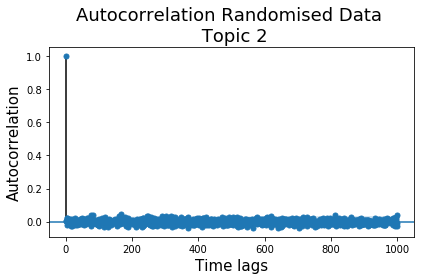

In [86]:
from matplotlib.pyplot import figure
figure(figsize=(10,7),dpi=300)
plot_acf(topics_per_time[2],lags=1000)
plt.xlabel("Time lags",size=15)
plt.ylabel("Autocorrelation",size=15)
plt.title("Autocorrelation Randomised Data \n Topic 2",size=18)
plt.tight_layout()
plt.savefig("topic2_random.png",dpi=300)